# **Evaluación de Modelos**
---

##*Pontificia Universidad Javeriana*
## *myMind*



**Juan José Gómez Arenas**



---






En este caso se va a realizar la prueba de varios modelos de sentimientos y de emociones con dos conjuntos de datos. Uno que corresponde a un set de datos estandarizado a partir de sen-eval-2018 y otro correspondiente a transcripciones generadas por NeMo de NVIDIA correspondientes a audios relacionados con el funcionamiento de myMind.

In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set de Datos Creado
En este caso, se evaluaran los modelos con respecto al set de datos creado, utilizando los datos demograficos ya establecido, y por otra parte, se utilizara para evaluar los modelos, las transcripciones generadas por el modelo de Nvidia NeMo ASR, pues a partir del rendimiento a comparación de los demás modelos, fue el que obtuvo mejor resultado en (WA) y con respecto a su tiempo de ejecución.

In [ ]:
df_demografico = pd.read_csv('/content/drive/MyDrive/categorizacionAudios.csv')
df_demografico.head()

,Audio,Emoción,Sentimiento,Edad,Ciudad/Localidad,Personalidad,Universidad,Carrera,Sexo
0,A001,Anger,Negative,22,Usaquen,Introvertido,Pontificia Universidad Javeriana,Ing. Sistemas,Masculino
1,A002,Joy,Neutral,22,Usaquen,Introvertido,Pontificia Universidad Javeriana,Ing. Sistemas,Masculino
2,A003,Sadness,Negative,22,Usaquen,Introvertido,Pontificia Universidad Javeriana,Ing. Sistemas,Masculino
3,A004,Joy,Positive,21,Suba,Introvertido,Pontificia Universidad Javeriana,Ing. Mecatronica,Masculino
4,A005,Joy,Positive,21,Suba,Introvertido,Pontificia Universidad Javeriana,Ing. Mecatronica,Masculino


In [ ]:

# 📂 Definir rutas
nemo_path = "/content/drive/MyDrive/Nemo/"

# 📌 Verificar si la carpeta de NeMo existe
if not os.path.exists(nemo_path):
    print(f"❌ No se encontró la carpeta: {nemo_path}")
else:
  transcripciones_dict = {}

  for archivo in os.listdir(nemo_path):
    if archivo.endswith("_T_NM.txt"):  # Solo transcripciones, no métricas
      nombre_audio = archivo.split("_")[0]  # e.g., "A001"
      ruta_archivo = os.path.join(nemo_path, archivo)

      with open(ruta_archivo, "r", encoding="utf-8") as f:
        texto_transcripcion = f.read().strip()

      transcripciones_dict[nombre_audio] = texto_transcripcion



In [ ]:
# Crear una nueva columna 'Transcripción' usando la columna 'Audio' como clave
df_demografico['Transcripción'] = df_demografico['Audio'].map(transcripciones_dict)

# Eliminar la columna original 'Audio'
df_demografico.drop(columns=['Audio'], inplace=True)

# Reordenar para que 'Transcripción' sea la primera columna
columnas = ['Transcripción'] + [col for col in df_demografico.columns if col != 'Transcripción']
df_demografico = df_demografico[columnas]

# Verificar el resultado
df_demografico.head()

,Transcripción,Emoción,Sentimiento,Edad,Ciudad/Localidad,Personalidad,Universidad,Carrera,Sexo
0,hoy estaba caminando me había comprado mi café...,Anger,Negative,22,Usaquen,Introvertido,Pontificia Universidad Javeriana,Ing. Sistemas,Masculino
1,hoy dicen panadas con mi mamá estuvimos mucho ...,Joy,Neutral,22,Usaquen,Introvertido,Pontificia Universidad Javeriana,Ing. Sistemas,Masculino
2,hoy me peleo con mi hermano no quería hacer lo...,Sadness,Negative,22,Usaquen,Introvertido,Pontificia Universidad Javeriana,Ing. Sistemas,Masculino
3,pues hoy me lance temprano porque el año de mi...,Joy,Positive,21,Suba,Introvertido,Pontificia Universidad Javeriana,Ing. Mecatronica,Masculino
4,en el mes de general en el mes de febrero me f...,Joy,Positive,21,Suba,Introvertido,Pontificia Universidad Javeriana,Ing. Mecatronica,Masculino



#Sentimientos
Se estandariza el conjunto de datos para que incluya la transcripción y los sentimientos, de manera que se pueda hacer la predicción.

In [ ]:
# Se filtran las columnas para que solo tenga el texto y el sentimiento
df_sentimientos = df_demografico[['Transcripción', 'Sentimiento']]
df_sentimientos['Sentimiento'] = df_sentimientos['Sentimiento'].str.lower().str.strip()
df_sentimientos.head()

<ipython-input-8-6a9ac4068d02>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentimientos['Sentimiento'] = df_sentimientos['Sentimiento'].str.lower().str.strip()


,Transcripción,Sentimiento
0,hoy estaba caminando me había comprado mi café...,negative
1,hoy dicen panadas con mi mamá estuvimos mucho ...,neutral
2,hoy me peleo con mi hermano no quería hacer lo...,negative
3,pues hoy me lance temprano porque el año de mi...,positive
4,en el mes de general en el mes de febrero me f...,positive


In [ ]:
df_sentimientos['Sentimiento'].value_counts()

,count
Sentimiento,
negative,32
neutral,31
positive,25


In [ ]:
# 📌 Crear un DataFrame para resultados
resultadosSentimientos = pd.DataFrame(columns=["Modelo", "Accuracy", "Precision", "Recall", "F1", "Tiempo (s)"])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Función para evaluar resultados
def evaluar_modelo(nombre_modelo, y_true, y_pred, tiempo_ejecucion):
    # Generar el reporte de clasificación
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    # Imprimir el reporte completo
    print(f"Classification Report para {nombre_modelo}:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Extraer las métricas específicas
    acc = report["accuracy"]
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1 = report["weighted avg"]["f1-score"]

    # Añadir resultados al DataFrame global
    resultadosSentimientos.loc[len(resultadosSentimientos)] = [nombre_modelo, acc, precision, recall, f1, round(tiempo_ejecucion, 2)]

    # 📊 Matriz de confusión
    etiquetas = ["positive", "neutral", "negative"]
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Pos", "Neu", "Neg"], yticklabels=["Pos", "Neu", "Neg"])
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()


## Pysentimiento


In [ ]:
%%capture
!pip install pysentimiento

In [ ]:
from pysentimiento import create_analyzer
import time

# 📌 Crear analizador de sentimientos en español
analyzer = create_analyzer(task="sentiment", lang="es")

# 📌 Entradas y etiquetas verdaderas
texts = df_sentimientos["Transcripción"].tolist()
true_labels = df_sentimientos["Sentimiento"].tolist()

# 📌 Función para predecir
def predict_sentiment_pysentimiento(text):
    result = analyzer.predict(text)
    return result.output.lower().strip()  # devuelve 'positive', 'negative', 'neutral'

# 📌 Evaluar modelo
start_time = time.time()
preds = [predict_sentiment_pysentimiento(text) for text in texts]
elapsed = time.time() - start_time




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Classification Report para PySentimiento:

              precision    recall  f1-score   support

    negative       0.60      0.88      0.71        32
     neutral       0.53      0.26      0.35        31
    positive       0.69      0.72      0.71        25

    accuracy                           0.61        88
   macro avg       0.61      0.62      0.59        88
weighted avg       0.60      0.61      0.58        88



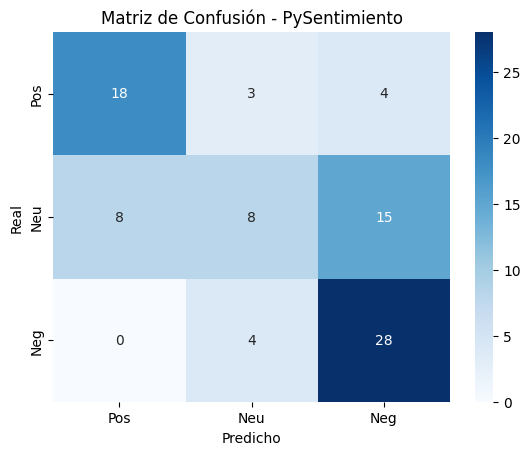

In [ ]:
# 📌 Mapeo para convertir predicciones a formato completo
label_map_pysentimiento = {
    "pos": "positive",
    "neg": "negative",
    "neu": "neutral"
}

# 📌 Convertir preds al mismo formato de las etiquetas verdaderas
preds_full_format = [label_map_pysentimiento.get(pred, pred) for pred in preds]
# 📌 Evaluar modelo
evaluar_modelo("PySentimiento", true_labels, preds_full_format, round(elapsed, 2))



##Vader

In [ ]:
%%capture
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 📌 Crear el analizador de VADER
analyzer_vader = SentimentIntensityAnalyzer()

# 📌 Función para predecir con VADER
def predict_sentiment_vader(text):
    # Obtener el puntaje de sentimiento para el texto
    sentiment_score = analyzer_vader.polarity_scores(text)
    # Asignar etiqueta en base al puntaje de sentimiento
    if sentiment_score["compound"] >= 0.05:
        return "positive"
    elif sentiment_score["compound"] <= -0.05:
        return "negative"
    else:
        return "neutral"

# 📌 Evaluar modelo
start_time = time.time()
preds_vader = [predict_sentiment_vader(text) for text in texts]  # Predicción con VADER
elapsed_vader = time.time() - start_time  # Tiempo de ejecución

Classification Report para VADER:

              precision    recall  f1-score   support

    negative       0.42      0.84      0.56        32
     neutral       0.40      0.13      0.20        31
    positive       0.23      0.12      0.16        25

    accuracy                           0.39        88
   macro avg       0.35      0.36      0.30        88
weighted avg       0.36      0.39      0.32        88



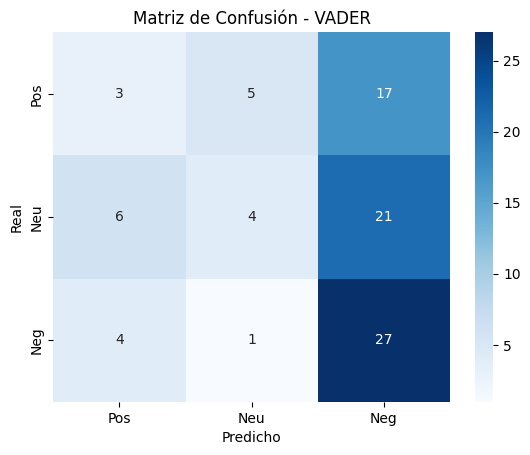

In [ ]:
# 📌 Llamar a la función de evaluación para VADER
evaluar_modelo("VADER", true_labels, preds_vader, elapsed_vader)

##Robertuito

In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import pipeline
import time

# Modelo entrenado en análisis de sentimiento en español
model_name = "pysentimiento/robertuito-sentiment-analysis"
classifier = pipeline("text-classification", model=model_name, tokenizer=model_name)

# Entradas y etiquetas verdaderas
texts = df_sentimientos["Transcripción"].tolist()
true_labels = df_sentimientos["Sentimiento"].tolist()

# 📌 Función con mapeo correcto
def predict_sentiment_robertuito(text):
    try:
        result = classifier(text, truncation=True)[0]

        return result["label"].lower()
    except Exception as e:
        print(f"Error: {e}")
        return "neutral"

# Evaluación
start_time = time.time()
preds = [predict_sentiment_robertuito(text) for text in texts]
elapsed = time.time() - start_time



Classification Report para RoBERTuito Sentiment:

              precision    recall  f1-score   support

    negative       0.60      0.88      0.71        32
     neutral       0.53      0.26      0.35        31
    positive       0.69      0.72      0.71        25

    accuracy                           0.61        88
   macro avg       0.61      0.62      0.59        88
weighted avg       0.60      0.61      0.58        88



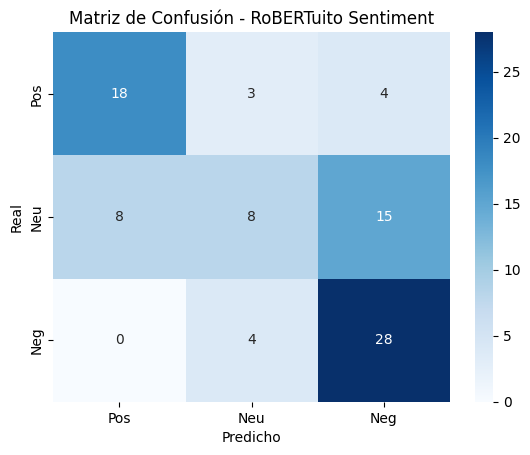

In [ ]:
label_map = {
    "pos": "positive",
    "neg": "negative",
    "neu": "neutral"
}

preds_mapeados = [label_map.get(label, "neutral") for label in preds]
evaluar_modelo("RoBERTuito Sentiment", true_labels, preds_mapeados, round(elapsed, 2))

A partir de los resultados obtenidos es posible evidenciar que corresponde al mismo modelo que carga pysentimiento por defecto, de manera que se omitira y se tomara el pysentimiento como referencia.

##finiteautomata/beto-sentiment-analysis

In [ ]:
from transformers import pipeline
import time

# 📌 Cargar modelo 'beto-sentiment-analysis'
model_name = "finiteautomata/beto-sentiment-analysis"
classifier = pipeline("text-classification", model=model_name, tokenizer=model_name)

# 📌 Entradas y etiquetas verdaderas
texts = df_sentimientos["Transcripción"].tolist()
true_labels = df_sentimientos["Sentimiento"].tolist()

# 📌 Función para predecir sentimiento
def predict_sentiment_beto(text):
    try:
        result = classifier(text, truncation=True)[0]
        label = result["label"].lower()

        return result["label"].lower()
    except Exception as e:
        print(f"Error: {e}")
        return "neutral"

# 📌 Evaluar modelo
start_time = time.time()
preds = [predict_sentiment_beto(text) for text in texts]
elapsed = time.time() - start_time


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/481k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Classification Report para finiteautomata/beto-sentiment-analysis:

              precision    recall  f1-score   support

    negative       0.51      0.81      0.63        32
     neutral       0.20      0.06      0.10        31
    positive       0.70      0.76      0.73        25

    accuracy                           0.53        88
   macro avg       0.47      0.55      0.48        88
weighted avg       0.46      0.53      0.47        88



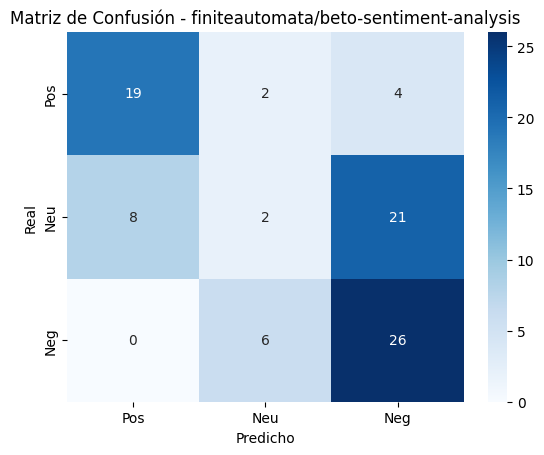

In [ ]:
label_map = {
            "pos": "positive",
            "neg": "negative",
            "neu": "neutral"
        }
# 📌 Convertir preds al mismo formato de las etiquetas verdaderas
preds_full_format = [label_map.get(pred, pred) for pred in preds]
# 📌 Evaluar modelo
evaluar_modelo("finiteautomata/beto-sentiment-analysis", true_labels, preds_full_format, round(elapsed, 2))

## lxyuan/distilbert-base-multilingual-cased-sentiments-student

In [ ]:
from transformers import pipeline
import time

# 📌 Cargar modelo 'distilbert-base-multilingual-cased-sentiments-student'
model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
classifier = pipeline("text-classification", model=model_name, tokenizer=model_name)

# 📌 Entradas y etiquetas verdaderas
texts = df_sentimientos["Transcripción"].tolist()
true_labels = df_sentimientos["Sentimiento"].tolist()

# 📌 Función para predecir sentimiento
def predict_sentiment_distilbert(text):
    try:
        result = classifier(text, truncation=True)[0]
        label = result["label"].lower()
        label_map = {
            "positive": "positive",
            "negative": "negative",
            "neutral": "neutral"
        }
        return label_map.get(label, "neutral")  # Valor por defecto
    except Exception as e:
        print(f"Error: {e}")
        return "neutral"

# 📌 Evaluar modelo
start_time = time.time()
preds = [predict_sentiment_distilbert(text) for text in texts]
elapsed = time.time() - start_time


config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Classification Report para lxyuan/distilbert-base-multilingual-cased-sentiments-student:

              precision    recall  f1-score   support

    negative       0.50      0.97      0.66        32
     neutral       0.00      0.00      0.00        31
    positive       0.56      0.56      0.56        25

    accuracy                           0.51        88
   macro avg       0.35      0.51      0.41        88
weighted avg       0.34      0.51      0.40        88



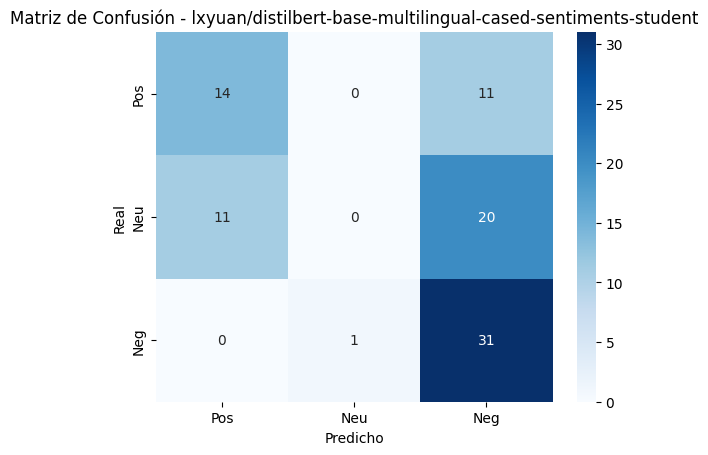

In [ ]:
# 📌 Evaluar modelo
evaluar_modelo("lxyuan/distilbert-base-multilingual-cased-sentiments-student", true_labels, preds, round(elapsed, 2))

## clapAI/roberta-large-multilingual-sentiment

In [ ]:
from transformers import pipeline
import time

# 📌 Cargar modelo 'roberta-large-multilingual-sentiment'
model_name = "clapAI/roberta-large-multilingual-sentiment"
classifier = pipeline("text-classification", model=model_name, tokenizer=model_name)

# 📌 Entradas y etiquetas verdaderas
texts = df_sentimientos["Transcripción"].tolist()
true_labels = df_sentimientos["Sentimiento"].tolist()

# 📌 Función para predecir sentimiento
def predict_sentiment_roberta(text):
    try:
        result = classifier(text, truncation=True)[0]
        label = result["label"].lower()
        label_map = {
            "positive": "positive",
            "negative": "negative",
            "neutral": "neutral"
        }
        return label_map.get(label, "neutral")  # Valor por defecto
    except Exception as e:
        print(f"Error: {e}")
        return "neutral"

# 📌 Evaluar modelo
start_time = time.time()
preds = [predict_sentiment_roberta(text) for text in texts]
elapsed = time.time() - start_time


config.json:   0%|          | 0.00/946 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Classification Report para clapAI/roberta-large-multilingual-sentiment:

              precision    recall  f1-score   support

    negative       0.55      0.88      0.67        32
     neutral       0.44      0.13      0.20        31
    positive       0.71      0.80      0.75        25

    accuracy                           0.59        88
   macro avg       0.57      0.60      0.54        88
weighted avg       0.56      0.59      0.53        88



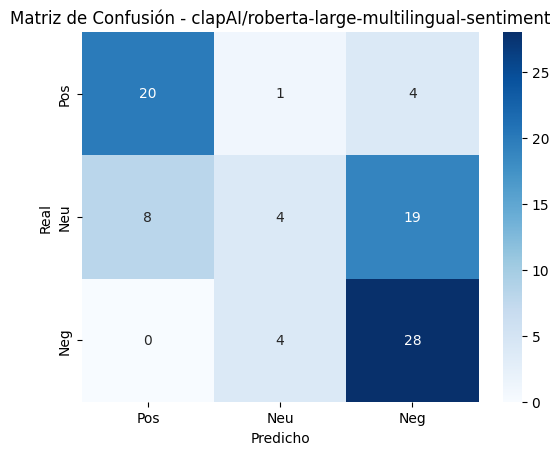

In [ ]:
# 📌 Evaluar modelo
evaluar_modelo("clapAI/roberta-large-multilingual-sentiment", true_labels, preds, round(elapsed, 2))

## tabularisai/multilingual-sentiment-analysis

In [ ]:
from transformers import pipeline
import time

# 📌 Cargar modelo 'multilingual-sentiment-analysis'
model_name = "tabularisai/multilingual-sentiment-analysis"
classifier = pipeline("text-classification", model=model_name, tokenizer=model_name)

# 📌 Entradas y etiquetas verdaderas
texts = df_sentimientos["Transcripción"].tolist()
true_labels = df_sentimientos["Sentimiento"].tolist()

# 📌 Función para predecir sentimiento
def predict_sentiment_multilingual(text):
    try:
        result = classifier(text, truncation=True)[0]
        label = result["label"].lower()
        label_map = {
            "positive": "positive",
            "negative": "negative",
            "neutral": "neutral"
        }
        return label_map.get(label, "neutral")  # Valor por defecto
    except Exception as e:
        print(f"Error: {e}")
        return "neutral"

# 📌 Evaluar modelo
start_time = time.time()
preds = [predict_sentiment_multilingual(text) for text in texts]
elapsed = time.time() - start_time


config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Classification Report para tabularisai/multilingual-sentiment-analysis:

              precision    recall  f1-score   support

    negative       0.33      0.03      0.06        32
     neutral       0.28      0.58      0.38        31
    positive       0.40      0.32      0.36        25

    accuracy                           0.31        88
   macro avg       0.34      0.31      0.26        88
weighted avg       0.33      0.31      0.25        88



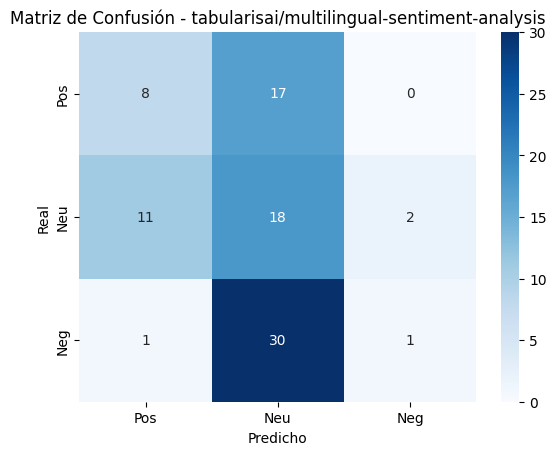

In [ ]:
# 📌 Evaluar modelo
evaluar_modelo("tabularisai/multilingual-sentiment-analysis", true_labels, preds, round(elapsed, 2))

# Resultados

In [ ]:
resultadosSentimientos.head(10)

,Modelo,Accuracy,Precision,Recall,F1,Tiempo (s)
0,PySentimiento,0.613636,0.601192,0.613636,0.580832,29.83
1,VADER,0.386364,0.357517,0.386364,0.316029,0.06
2,RoBERTuito Sentiment,0.613636,0.601192,0.613636,0.580832,62.27
3,finiteautomata/beto-sentiment-analysis,0.534091,0.455754,0.534091,0.469793,58.82
4,lxyuan/distilbert-base-multilingual-cased-sent...,0.511364,0.340909,0.511364,0.398936,19.78
5,clapAI/roberta-large-multilingual-sentiment,0.590909,0.559131,0.590909,0.530208,128.14
6,tabularisai/multilingual-sentiment-analysis,0.306818,0.332401,0.306818,0.253892,18.83


#FineTuning
En este caso, se busco verificar si es posible utilizar finetuning para un modelo de manera que se pueda adaptar para los datos especificos en el contexto de myMind, y verificar si el rendimiento mejor, pues hasta el momento, el modelo con la mayor capacidad predictora es Pysentimiento (RoBERTuito)


In [ ]:
%%capture
!pip install datasets evaluate torch accelerate

In [ ]:
df_sentimientos.rename(columns={'Sentimiento': 'labels'}, inplace=True)
df_sentimientos.rename(columns={'Transcripción': 'text'}, inplace=True)
df_sentimientos.head()

<ipython-input-31-ffa03105a711>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentimientos.rename(columns={'Sentimiento': 'labels'}, inplace=True)
<ipython-input-31-ffa03105a711>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentimientos.rename(columns={'Transcripción': 'text'}, inplace=True)


,text,labels
0,hoy estaba caminando me había comprado mi café...,negative
1,hoy dicen panadas con mi mamá estuvimos mucho ...,neutral
2,hoy me peleo con mi hermano no quería hacer lo...,negative
3,pues hoy me lance temprano porque el año de mi...,positive
4,en el mes de general en el mes de febrero me f...,positive


In [ ]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
df_sentimientos["labels"] = df_sentimientos["labels"].map(label2id)

<ipython-input-32-677fededd031>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentimientos["labels"] = df_sentimientos["labels"].map(label2id)


In [ ]:
df_sentimientos.head()

,text,labels
0,hoy estaba caminando me había comprado mi café...,0
1,hoy dicen panadas con mi mamá estuvimos mucho ...,1
2,hoy me peleo con mi hermano no quería hacer lo...,0
3,pues hoy me lance temprano porque el año de mi...,2
4,en el mes de general en el mes de febrero me f...,2


In [ ]:
from datasets import Dataset

# Convertir a HuggingFace Dataset
dataset = Dataset.from_pandas(df_sentimientos)
dataset = dataset.train_test_split(test_size=0.8, seed=42)

## RoBERTuito Finetuned

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# =======================
# Configuración del modelo
# =======================
model_name = "pysentimiento/robertuito-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = example["labels"]
    return tokens

tokenized_dataset = dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# =======================
# Extraer etiquetas
# =======================
y_train = tokenized_dataset["train"]["labels"]

# =======================
# Asegurarse de que las clases sean enteros únicos
# =======================
unique_classes = np.unique(y_train)  # Los valores únicos de las etiquetas (esto debería ser enteros)

# =======================
# Calcular pesos de clase
# =======================
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Verificar los pesos calculados
for label, weight in zip(unique_classes, class_weights):
    print(f"Clase {id2label[label]} ({label}) -> Peso: {weight:.3f}")

Clase negative (0) -> Peso: 0.944
Clase neutral (1) -> Peso: 1.133
Clase positive (2) -> Peso: 0.944


In [ ]:
from transformers import AutoModelForSequenceClassification

# =======================
# Modelo
# =======================
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)


In [ ]:
# Modificar la función de pérdida del modelo
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

model.compute_loss = compute_loss_with_weights

In [ ]:
import evaluate
import numpy as np

# Cargar métricas
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Función para calcular múltiples métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
    }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./robertuito-finetuned",
    eval_strategy="epoch",               # Evalúa al final de cada época
    save_strategy="epoch",                     # Guarda el modelo al final de cada época
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,                        # ← Epocas para entrenamiento
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",                # Puedes cambiarlo a "accuracy" si prefieres
    report_to="none"                           # Evita que se conecte a Weights & Biases
)


In [ ]:
from transformers import Trainer, EarlyStoppingCallback


# ==========================
# Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Detener si no hay mejora después de 3 épocas
)

<ipython-input-41-b4b085a10fd9>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

{'eval_loss': 0.9803645014762878, 'eval_accuracy': 0.6056338028169014, 'eval_precision': 0.5952729044834308, 'eval_recall': 0.6221322537112011, 'eval_f1': 0.5673795681063122, 'eval_runtime': 28.1297, 'eval_samples_per_second': 2.524, 'eval_steps_per_second': 0.32, 'epoch': 1.0}
{'eval_loss': 1.0029115676879883, 'eval_accuracy': 0.6197183098591549, 'eval_precision': 0.623421052631579, 'eval_recall': 0.6396761133603238, 'eval_f1': 0.5800467914438503, 'eval_runtime': 28.0064, 'eval_samples_per_second': 2.535, 'eval_steps_per_second': 0.321, 'epoch': 2.0}
{'eval_loss': 1.0395700931549072, 'eval_accuracy': 0.6056338028169014, 'eval_precision': 0.6029894460435287, 'eval_recall': 0.6221322537112012, 'eval_f1': 0.5577092890525727, 'eval_runtime': 26.7727, 'eval_samples_per_second': 2.652, 'eval_steps_per_second': 0.336, 'epoch': 3.0}
{'eval_loss': 1.093468189239502, 'eval_accuracy': 0.6056338028169014, 'eval_precision': 0.6029894460435287, 'eval_recall': 0.6221322537112012, 'eval_f1': 0.557709

TrainOutput(global_step=15, training_loss=0.46777222951253256, metrics={'train_runtime': 421.319, 'train_samples_per_second': 0.605, 'train_steps_per_second': 0.107, 'train_loss': 0.46777222951253256, 'epoch': 5.0})

Classification Report para RoBERTuito FineTuned:

              precision    recall  f1-score   support

    negative       0.61      0.88      0.72        26
     neutral       0.62      0.19      0.29        26
    positive       0.64      0.84      0.73        19

    accuracy                           0.62        71
   macro avg       0.62      0.64      0.58        71
weighted avg       0.62      0.62      0.57        71



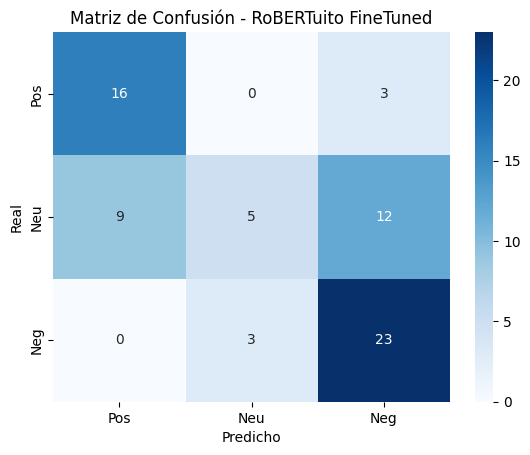

In [ ]:
# Obtener predicciones
start_time = time.time()
predicciones = trainer.predict(tokenized_dataset["test"])
elapsed_time = time.time() - start_time
# Acceder a los logits y convertir a clases
import numpy as np

logits = predicciones.predictions
preds = np.argmax(logits, axis=-1)
labels = predicciones.label_ids

# Mapear IDs a etiquetas si quieres ver los resultados
y_pred = [id2label[p] for p in preds]
y_true = [id2label[l] for l in labels]

# Evaluar con tu función personalizada
evaluar_modelo("RoBERTuito FineTuned", y_true, y_pred, elapsed_time)


## BERT Multilingual Finetuned

clapAI/roberta-large-multilingual-sentiment (RoBERTa multilingual)

lxyuan/distilbert-base-multilingual-cased-sentiments-student

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
from datasets import Dataset, DatasetDict
import tensorflow as tf
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_NO_TF"] = "1"  # Fuerza el uso de PyTorch


In [ ]:
model_path = "google-bert/bert-base-multilingual-cased"


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained( model_path,
                                                            num_labels=3,
                                                            id2label=id2label,
                                                            label2id=label2id)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
# Congelar todas las capas del encoder
for name, param in model.bert.named_parameters():
    param.requires_grad = False

# Descongelar solo la capa pooler
for name, param in model.bert.named_parameters():
        param.requires_grad = True


In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(df_sentimientos)


In [ ]:
def preprocess_function(examples):
  #return tokenized text with truncation
  return tokenizer(examples["text"], truncation=True)

# Preprocess al dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

Map:   0%|          | 0/88 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from sklearn.metrics import roc_auc_score
# Metricas
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
  #Get predictions
  predictions, labels = eval_pred
  probabilities = np.exp(predictions)/ np.exp(predictions).sum(-1, keepdims=True)
  positive_class_probs = probabilities[:, 2]
  auc = roc_auc_score(labels, probabilities, multi_class="ovr")

  predicted_classes = np.argmax(predictions, axis=1)
  acc = np.round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'],3)

  return {'auc': auc, 'accuracy': acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-finetuned",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


<ipython-input-54-9c245818256d>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

{'loss': 1.1324, 'grad_norm': 10.107382774353027, 'learning_rate': 0.00018222222222222224, 'epoch': 1.0}
{'eval_loss': 1.1725780963897705, 'eval_auc': 0.48728354978354976, 'eval_accuracy': 0.389, 'eval_runtime': 9.7194, 'eval_samples_per_second': 1.852, 'eval_steps_per_second': 0.309, 'epoch': 1.0}
{'loss': 1.1555, 'grad_norm': 5.660179615020752, 'learning_rate': 0.00016222222222222224, 'epoch': 2.0}
{'eval_loss': 1.1892526149749756, 'eval_auc': 0.5008116883116883, 'eval_accuracy': 0.222, 'eval_runtime': 8.1054, 'eval_samples_per_second': 2.221, 'eval_steps_per_second': 0.37, 'epoch': 2.0}
{'loss': 1.1108, 'grad_norm': 3.0190248489379883, 'learning_rate': 0.00014222222222222224, 'epoch': 3.0}
{'eval_loss': 1.103238582611084, 'eval_auc': 0.5048701298701298, 'eval_accuracy': 0.389, 'eval_runtime': 8.3378, 'eval_samples_per_second': 2.159, 'eval_steps_per_second': 0.36, 'epoch': 3.0}
{'loss': 1.1524, 'grad_norm': 5.167347431182861, 'learning_rate': 0.00012222222222222224, 'epoch': 4.0}
{'

TrainOutput(global_step=90, training_loss=1.1175745540195041, metrics={'train_runtime': 2606.9319, 'train_samples_per_second': 0.269, 'train_steps_per_second': 0.035, 'train_loss': 1.1175745540195041, 'epoch': 10.0})

Classification Report para BERT Multilingual Finetuned:

              precision    recall  f1-score   support

    negative       0.39      1.00      0.56         7
     neutral       0.00      0.00      0.00         4
    positive       0.00      0.00      0.00         7

    accuracy                           0.39        18
   macro avg       0.13      0.33      0.19        18
weighted avg       0.15      0.39      0.22        18



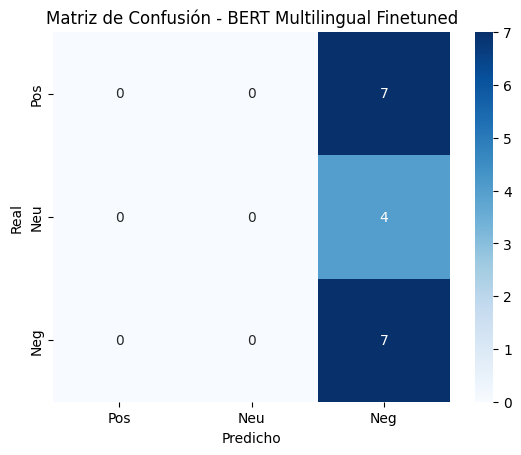

In [ ]:
# Obtener predicciones
start_time = time.time()
predicciones = trainer.predict(tokenized_dataset["test"])
elapsed_time = time.time() - start_time
# Acceder a los logits y convertir a clases
import numpy as np

logits = predicciones.predictions
preds = np.argmax(logits, axis=-1)
labels = predicciones.label_ids

# Mapear IDs a etiquetas si quieres ver los resultados
y_pred = [id2label[p] for p in preds]
y_true = [id2label[l] for l in labels]

# Evaluar con tu función personalizada
evaluar_modelo("BERT Multilingual Finetuned", y_true, y_pred, elapsed_time)


# Resultados Finales Sentimientos

In [ ]:
resultadosSentimientos.head(10)

,Modelo,Accuracy,Precision,Recall,F1,Tiempo (s)
0,PySentimiento,0.613636,0.601192,0.613636,0.580832,29.83
1,VADER,0.386364,0.357517,0.386364,0.316029,0.06
2,RoBERTuito Sentiment,0.613636,0.601192,0.613636,0.580832,62.27
3,finiteautomata/beto-sentiment-analysis,0.534091,0.455754,0.534091,0.469793,58.82
4,lxyuan/distilbert-base-multilingual-cased-sent...,0.511364,0.340909,0.511364,0.398936,19.78
5,clapAI/roberta-large-multilingual-sentiment,0.590909,0.559131,0.590909,0.530208,128.14
6,tabularisai/multilingual-sentiment-analysis,0.306818,0.332401,0.306818,0.253892,18.83
7,RoBERTuito FineTuned,0.619718,0.621787,0.619718,0.565532,26.91
8,BERT Multilingual Finetuned,0.388889,0.151235,0.388889,0.217778,9.21


# Emociones


In [ ]:
df_emociones = df_demografico[['Transcripción', 'Emoción']]
df_emociones['Emoción'] = df_emociones['Emoción'].str.lower().str.strip()
df_emociones.head()

<ipython-input-6-d4a23d6d0f80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emociones['Emoción'] = df_emociones['Emoción'].str.lower().str.strip()


,Transcripción,Emoción
0,hoy estaba caminando me había comprado mi café...,anger
1,hoy dicen panadas con mi mamá estuvimos mucho ...,joy
2,hoy me peleo con mi hermano no quería hacer lo...,sadness
3,pues hoy me lance temprano porque el año de mi...,joy
4,en el mes de general en el mes de febrero me f...,joy


In [ ]:
df_emociones.loc[df_emociones['Emoción'] == 'joy/trust', 'Emoción'] = 'trust'

In [ ]:
df_emociones['Emoción'].value_counts()

,count
Emoción,
joy,23
anger,14
sadness,12
disgust,9
fear,8
trust,7
anticipation,6
neutral,5
surprise,4


In [ ]:
# 📌 Crear un DataFrame para resultados
resultadosEmociones = pd.DataFrame(columns=["Modelo", "Accuracy", "Precision", "Recall", "F1", "Tiempo (s)"])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Etiquetas soportadas por el modelo
etiquetas_emociones = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust', 'others']

# 📌 Función adaptada
def evaluar_modelo_emociones(nombre_modelo, y_true, y_pred, tiempo_ejecucion):
    report = classification_report(y_true, y_pred, labels=etiquetas_emociones, output_dict=True, zero_division=0)

    print(f"Classification Report para {nombre_modelo}:\n")
    print(classification_report(y_true, y_pred, labels=etiquetas_emociones, zero_division=0))

     # Calcular accuracy manual si no está en el diccionario
    acc = report["accuracy"] if "accuracy" in report else accuracy_score(y_true, y_pred)
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1 = report["weighted avg"]["f1-score"]

    resultadosEmociones.loc[len(resultadosEmociones)] = [nombre_modelo, acc, precision, recall, f1, round(tiempo_ejecucion, 2)]

    cm = confusion_matrix(y_true, y_pred, labels=etiquetas_emociones)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=etiquetas_emociones, yticklabels=etiquetas_emociones)
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()


## Robertuito

### Etiquetas del modelo
En este caso se toman las clases que no corresponden a las salidas del modelo como la clase de "Others" del modelo

In [ ]:
from pysentimiento import create_analyzer
import time

# Cargar el analizador de emociones
emotion_analyzer = create_analyzer(task="emotion", lang="es")



config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
# 🛠 Función para mapear la emoción
def mapear_emocion_con_modelo_v2(probas, emociones_principales=['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise'], umbral_others=0.85):
    # Ordenar emociones por probabilidad
    ordenadas = sorted(probas.items(), key=lambda x: x[1], reverse=True)
    emocion_predicha, prob_predicha = ordenadas[0]

    # 🎯 Caso 1: Si la emoción predicha está en las emociones principales, devolverla
    if emocion_predicha in emociones_principales:
        return emocion_predicha

    # 🎯 Caso 2: Si la emoción predicha no está en las emociones principales, devolver "others"
    return 'others'


In [ ]:
# 🔁 Predecir emociones para cada transcripción
def predecir_emociones_robertuito(textos):
    predicciones = []
    probabilidades = []

    for texto in textos:
        resultado = emotion_analyzer.predict(texto)
        # Usamos la función de mapeo para cada probabilidad
        prediccion = mapear_emocion_con_modelo_v2(resultado.probas)
        predicciones.append(prediccion)
        probabilidades.append(resultado.probas)  # Diccionario con probabilidades por emoción

    return predicciones, probabilidades

Classification Report para robertuito-emotion-analysis:

              precision    recall  f1-score   support

         joy       0.75      0.52      0.62        23
     sadness       0.64      0.58      0.61        12
       anger       0.62      0.71      0.67        14
        fear       1.00      0.12      0.22         8
    surprise       1.00      0.25      0.40         4
     disgust       0.00      0.00      0.00         9
      others       0.00      0.00      0.00         0

   micro avg       0.35      0.44      0.39        70
   macro avg       0.57      0.31      0.36        70
weighted avg       0.65      0.44      0.49        70



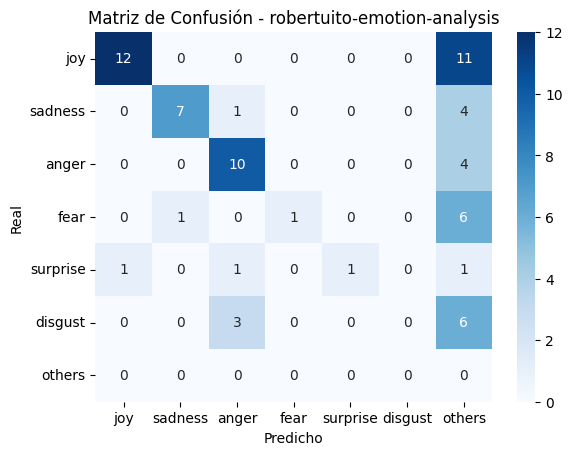

In [ ]:
textos = df_emociones["Transcripción"].tolist()
y_true = df_emociones["Emoción"].tolist()

start = time.time()
y_pred, probabilidades = predecir_emociones_robertuito(textos)
end = time.time()

# Evaluar el modelo con las predicciones
evaluar_modelo_emociones("robertuito-emotion-analysis", y_true, y_pred, end - start)

### Etiquetas manuales
En este caso se establece un criterio de probabilidades de la salida del modelo para adaptar las salidas que se obtienen a las categorias definidas en el conjunto de datos original.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Etiquetas personalizadas
etiquetas_personalizadas = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'neutral', 'surprise', 'trust', 'anticipation']

# 📌 Evaluación personalizada
def evaluar_modelo_emociones_personalizada(nombre_modelo, y_true, y_pred, tiempo_ejecucion):
    report = classification_report(y_true, y_pred, labels=etiquetas_personalizadas, output_dict=True, zero_division=0)

    print(f"\n📊 Classification Report (Personalizado) para {nombre_modelo}:\n")
    print(classification_report(y_true, y_pred, labels=etiquetas_personalizadas, zero_division=0))

    acc = report.get("accuracy", 0.0)
    precision = report.get("weighted avg", {}).get("precision", 0.0)
    recall = report.get("weighted avg", {}).get("recall", 0.0)
    f1 = report.get("weighted avg", {}).get("f1-score", 0.0)



    # Guardar resultados en el DataFrame global
    resultadosEmociones.loc[len(resultadosEmociones)] = [nombre_modelo, acc, precision, recall, f1, round(tiempo_ejecucion, 2)]

    # 📉 Matriz de Confusión
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas_personalizadas)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Purples", xticklabels=etiquetas_personalizadas, yticklabels=etiquetas_personalizadas)
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
def mapear_emocion_personalizada(probas, emocion_real=None, umbral_others=0.85, umbral_neutral=0.005, umbral_opuesto=0.15):
    """
    Mapea la salida de emociones del modelo robertuito a una emoción extendida,
    incluyendo 'trust', 'anticipation' y 'neutral', cuando se predice 'others'.

    Se apoya en emociones opuestas de Plutchik solo si la emoción real no está en las del modelo base.
    """

    emociones_principales = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise']
    emocion_predicha = max(probas, key=probas.get)
    prob_predicha = probas[emocion_predicha]

    # Diccionario de opuestos (Plutchik)
    opuestos = {
        'joy': 'sadness',
        'sadness': 'joy',
        'anger': 'fear',
        'fear': 'anger',
        'anticipation': 'surprise',
        'surprise': 'anticipation',
        'trust': 'disgust',
        'disgust': 'trust',
    }

    # ✅ Caso 1: Si la emoción predicha es una emoción principal
    if emocion_predicha in emociones_principales:
        return emocion_predicha

    # ✅ Caso 2: El modelo predice "others"
    if emocion_predicha == 'others':

        # 2.1: Muy baja activación emocional → neutral
        suma_emociones_principales = sum(probas[e] for e in emociones_principales)
        if suma_emociones_principales < umbral_neutral:
            return 'neutral'

        # 2.2: Si la emoción real no está en las del modelo → usar opuestos
        if emocion_real not in emociones_principales:
            emociones_ordenadas = sorted(
                [(e, p) for e, p in probas.items() if e in emociones_principales],
                key=lambda x: x[1], reverse=True
            )

            for emocion, prob in emociones_ordenadas:
                emocion_opuesta = opuestos.get(emocion)
                prob_opuesta = probas.get(emocion_opuesta, 0)
                if prob >= umbral_others and prob_opuesta < umbral_opuesto:
                    return emocion

        # 2.3: Si emoción real sí está en las del modelo → tomar la emoción secundaria más fuerte
        emociones_ordenadas = sorted(
            [(e, p) for e, p in probas.items() if e in emociones_principales],
            key=lambda x: x[1], reverse=True
        )
        if emociones_ordenadas:
            return emociones_ordenadas[0][0]


    # ✅ Caso final: cualquier otro (por si acaso)
    return emocion_predicha



📊 Classification Report (Personalizado) para robertuito-emotion-analysis-personalizado:

              precision    recall  f1-score   support

         joy       0.64      0.78      0.71        23
       anger       0.50      0.79      0.61        14
     sadness       0.28      0.75      0.41        12
     disgust       0.00      0.00      0.00         9
        fear       1.00      0.12      0.22         8
     neutral       0.00      0.00      0.00         5
    surprise       0.20      0.25      0.22         4
       trust       0.00      0.00      0.00         7
anticipation       0.00      0.00      0.00         6

    accuracy                           0.45        88
   macro avg       0.29      0.30      0.24        88
weighted avg       0.39      0.45      0.37        88



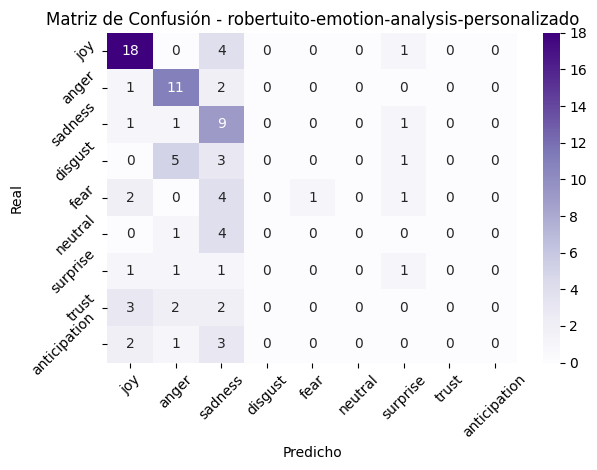

In [ ]:
# Paso 1: Obtener las predicciones
textos = df_emociones["Transcripción"].tolist()
y_true = df_emociones["Emoción"].tolist()

start = time.time()
_, probabilidades = predecir_emociones_robertuito(textos)  # Ya la tenías definida
end = time.time()

# Paso 2: Mapear a tus emociones personalizadas
y_pred_personalizado = [mapear_emocion_personalizada(p) for p in probabilidades]


# Paso 3: Evaluar usando la función personalizada
evaluar_modelo_emociones_personalizada("robertuito-emotion-analysis-personalizado", y_true, y_pred_personalizado, end - start)


## T5

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Emociones soportadas por el modelo
emociones_t5 = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Cargar modelo T5 fine-tuned
tokenizer_t5 = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-emotion")

# Función de predicción
def predecir_emocion_t5(texto):
    entrada = f"emotion: {texto}"
    inputs = tokenizer_t5(entrada, return_tensors="pt", truncation=True)
    with torch.no_grad():
        output = model_t5.generate(**inputs)
    emocion = tokenizer_t5.decode(output[0], skip_special_tokens=True)
    return emocion.strip().lower()

# Aplicar sobre DataFrame (puedes reemplazar df_emociones por tu DataFrame real)
def evaluar_modelo_t5(df_emociones):
    y_true = []
    y_pred = []
    start = time.time()

    for _, row in tqdm(df_emociones.iterrows(), total=len(df_emociones)):
        texto = row['Transcripción']
        emocion_real = row['Emoción'].lower()
        emocion_predicha = predecir_emocion_t5(texto)

        # Clasificamos como 'other' si no está en el set del modelo
        if emocion_predicha not in emociones_t5:
            emocion_predicha = "other"

        y_true.append(emocion_real if emocion_real in emociones_t5 else "other")
        y_pred.append(emocion_predicha)

    end = time.time()
    tiempo_total = end - start

    print("\n🧪 Classification Report:")
    print(classification_report(y_true, y_pred, labels=emociones_t5 + ["other"], zero_division=0))
    report = classification_report(y_true, y_pred, labels=emociones_t5 + ["other"], output_dict=True, zero_division=0)
    acc = report.get("accuracy", 0.0)
    precision = report.get("weighted avg", {}).get("precision", 0.0)
    recall = report.get("weighted avg", {}).get("recall", 0.0)
    f1 = report.get("weighted avg", {}).get("f1-score", 0.0)



    # Guardar resultados en el DataFrame global
    resultadosEmociones.loc[len(resultadosEmociones)] = ["T5", acc, precision, recall, f1, round(tiempo_total, 2)]
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=emociones_t5 + ["other"])
    sns.heatmap(cm, annot=True, xticklabels=emociones_t5 + ["other"], yticklabels=emociones_t5 + ["other"], cmap="Blues")
    plt.title("Confusion Matrix - T5 Emotion Classifier")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return y_true, y_pred, tiempo_total


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

  1%|          | 1/88 [00:01<01:32,  1.06s/it]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

100%|██████████| 88/88 [01:32<00:00,  1.06s/it]



🧪 Classification Report:
              precision    recall  f1-score   support

     sadness       0.50      0.42      0.45        12
         joy       0.31      0.96      0.46        23
        love       0.00      0.00      0.00         0
       anger       0.00      0.00      0.00        14
        fear       0.25      0.12      0.17         8
    surprise       0.00      0.00      0.00         4
       other       0.00      0.00      0.00        27

    accuracy                           0.32        88
   macro avg       0.15      0.21      0.15        88
weighted avg       0.17      0.32      0.20        88



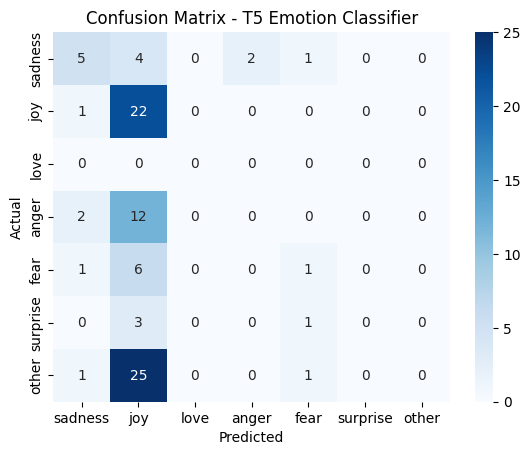

In [ ]:
y_true, y_pred, tiempo_t5 = evaluar_modelo_t5(df_emociones)


## BETO

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Emociones soportadas por el modelo BETO
emociones_beto = ['joy', 'anger', 'sadness', 'fear', 'disgust', 'surprise', 'neutral']

# Cargar modelo BETO fine-tuned para análisis de emociones
tokenizer_beto = AutoTokenizer.from_pretrained("finiteautomata/beto-emotion-analysis")
model_beto = AutoModelForSequenceClassification.from_pretrained("finiteautomata/beto-emotion-analysis")

# Función de predicción
def predecir_emocion_beto(texto):
    inputs = tokenizer_beto(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        output = model_beto(**inputs)
    logits = output.logits
    probas = torch.nn.functional.softmax(logits, dim=-1)
    emocion_predicha = emociones_beto[torch.argmax(probas)]
    return emocion_predicha

# Evaluar modelo sobre DataFrame (suponiendo que tienes un DataFrame con las transcripciones y emociones)
def evaluar_modelo_beto(df_emociones):
    y_true = []
    y_pred = []
    start = time.time()

    for _, row in tqdm(df_emociones.iterrows(), total=len(df_emociones)):
        texto = row['Transcripción']
        emocion_real = row['Emoción'].lower()
        emocion_predicha = predecir_emocion_beto(texto)

        # Solo tomar en cuenta las emociones que el modelo puede predecir
        if emocion_predicha in emociones_beto:
            y_true.append(emocion_real if emocion_real in emociones_beto else "other")
            y_pred.append(emocion_predicha)

    end = time.time()
    tiempo_total = end - start

    # Imprimir el reporte de clasificación
    print("\n🧪 Classification Report:")
    print(classification_report(y_true, y_pred, labels=emociones_beto + ["other"], zero_division=0))
    report = classification_report(y_true, y_pred, labels=emociones_beto + ["other"], output_dict=True, zero_division=0)
    acc = report.get("accuracy", 0.0)
    precision = report.get("weighted avg", {}).get("precision", 0.0)
    recall = report.get("weighted avg", {}).get("recall", 0.0)
    f1 = report.get("weighted avg", {}).get("f1-score", 0.0)

    resultadosEmociones.loc[len(resultadosEmociones)] = ["BETO", acc, precision, recall, f1, round(tiempo_total, 2)]

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=emociones_beto)
    sns.heatmap(cm, annot=True, xticklabels=emociones_beto, yticklabels=emociones_beto, cmap="Blues")
    plt.title("Confusion Matrix - BETO Emotion Classifier")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return y_true, y_pred, tiempo_total


tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/481k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

100%|██████████| 88/88 [00:39<00:00,  2.24it/s]



🧪 Classification Report:
              precision    recall  f1-score   support

         joy       0.10      0.13      0.12        23
       anger       0.00      0.00      0.00        14
     sadness       0.64      0.75      0.69        12
        fear       0.06      0.12      0.08         8
     disgust       0.00      0.00      0.00         9
    surprise       0.00      0.00      0.00         4
     neutral       0.00      0.00      0.00         5
       other       0.00      0.00      0.00        13

    accuracy                           0.15        88
   macro avg       0.10      0.13      0.11        88
weighted avg       0.12      0.15      0.13        88



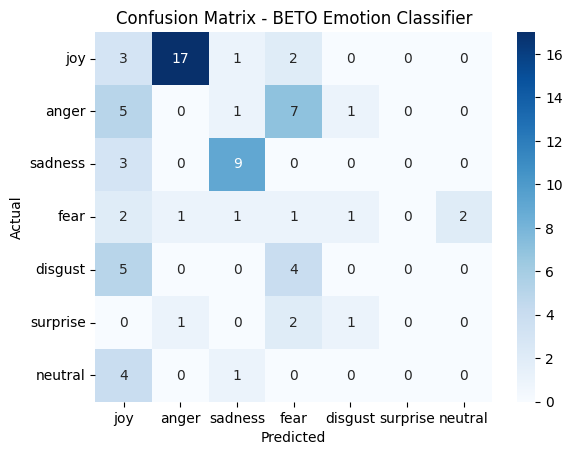

In [ ]:
y_true, y_pred, tiempo_beto = evaluar_modelo_beto(df_emociones)


## XLM

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Emociones soportadas por el modelo xlm-emo-t
emociones_xlmemo = ['joy', 'anger', 'fear', 'sadness']

# Cargar modelo y tokenizer
tokenizer_xlmemo = AutoTokenizer.from_pretrained("MilaNLProc/xlm-emo-t")
model_xlmemo = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/xlm-emo-t")

# Función de predicción
def predecir_emocion_xlmemo(texto):
    inputs = tokenizer_xlmemo(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        output = model_xlmemo(**inputs)
    logits = output.logits
    probas = torch.nn.functional.softmax(logits, dim=-1)
    emocion_predicha = emociones_xlmemo[torch.argmax(probas)]
    return emocion_predicha

# Evaluar modelo sobre DataFrame (como df_sentimientos)
def evaluar_modelo_xlmemo(df_emociones):
    y_true = []
    y_pred = []
    start = time.time()

    for _, row in tqdm(df_emociones.iterrows(), total=len(df_emociones)):
        texto = row['Transcripción']
        emocion_real = row['Emoción'].lower()
        emocion_predicha = predecir_emocion_xlmemo(texto)

        # Solo tomar en cuenta emociones que el modelo puede predecir
        if emocion_predicha in emociones_xlmemo:
            y_true.append(emocion_real if emocion_real in emociones_xlmemo else "other")
            y_pred.append(emocion_predicha)

    end = time.time()
    tiempo_total = end - start

    # Imprimir el reporte de clasificación
    print("\n🧪 Classification Report:")
    report = classification_report(y_true, y_pred, labels=emociones_xlmemo + ["other"], output_dict=True, zero_division=0)
    acc = report.get("accuracy", 0.0)
    precision = report.get("weighted avg", {}).get("precision", 0.0)
    recall = report.get("weighted avg", {}).get("recall", 0.0)
    f1 = report.get("weighted avg", {}).get("f1-score", 0.0)

    resultadosEmociones.loc[len(resultadosEmociones)] = ["XLM-EMO-T", acc, precision, recall, f1, round(tiempo_total, 2)]

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=emociones_xlmemo + ["other"])
    sns.heatmap(cm, annot=True, xticklabels=emociones_xlmemo + ["other"],
                yticklabels=emociones_xlmemo + ["other"], cmap="Purples")
    plt.title("Confusion Matrix - XLM-EMO-T Emotion Classifier")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return y_true, y_pred, tiempo_total


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]


100%|██████████| 88/88 [00:50<00:00,  1.74it/s]



🧪 Classification Report:


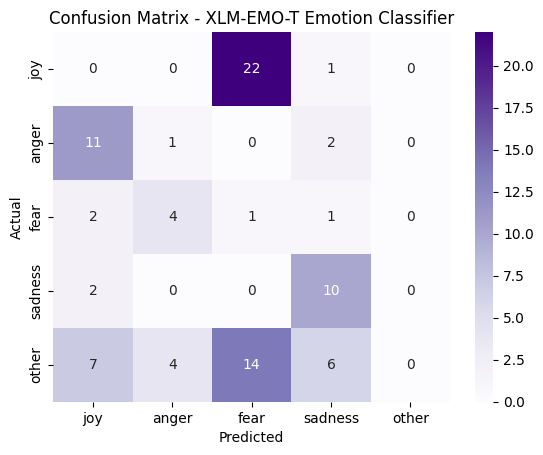

In [ ]:
# Suponiendo que tienes un DataFrame llamado df_sentimientos
y_true, y_pred, tiempo = evaluar_modelo_xlmemo(df_emociones)


## Resultados

In [ ]:
resultadosEmociones.head(10)

,Modelo,Accuracy,Precision,Recall,F1,Tiempo (s)
0,robertuito-emotion-analysis,0.352273,0.651948,0.442857,0.488133,32.73
1,robertuito-emotion-analysis-personalizado,0.454545,0.385917,0.454545,0.367802,34.29
2,T5,0.318182,0.170770,0.318182,0.198188,92.99
3,BETO,0.147727,0.120382,0.147727,0.132139,39.33
4,XLM-EMO-T,0.136364,0.088316,0.136364,0.103102,50.70


# Finetuning

Se intento probar los modelos con las etiquetas propias de los modelos para que estas fueran capaces de clasificar (al menos) las que tuvieran como salidas propias de los modelos. No obstante, como fue posible evidenciar, el rendimiento en general de los modelos fue bastante bajo en terminos generales, como se ve en la tabla comparativa.

In [ ]:
%%capture
!pip install datasets evaluate torch accelerate transformers

## pysentimiento/robertuito-emotion-analysis

In [ ]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

# Asegúrate de que el DataFrame se llama df_emociones y tiene las columnas 'Transcripción' y 'Emoción'
df_emociones = df_emociones.rename(columns={"Transcripción": "text", "Emoción": "labels"})

# Codificar etiquetas
label_encoder = LabelEncoder()
df_emociones["labels"] = label_encoder.fit_transform(df_emociones["labels"])

label2id = {
    "joy": 0,
    "anger": 1,
    "sadness": 2,
    "disgust": 3,
    "fear": 4,
    "neutral": 5,
    "trust": 6,
    "surprise": 7,
    "anticipation": 8
}

id2label = {v: k for k, v in label2id.items()}

# Convertir a Dataset y hacer split
dataset = Dataset.from_pandas(df_emociones)
dataset = dataset.train_test_split(test_size=0.2, seed=42)


In [ ]:
from transformers import AutoTokenizer

model_name = "pysentimiento/robertuito-emotion-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = example["labels"]
    return tokens

tokenized_dataset = dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

y_train = tokenized_dataset["train"]["labels"]
unique_classes = np.unique(y_train)
# Balancear pesos de las clases
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [ ]:
from transformers import AutoModelForSequenceClassification

# Cargar el modelo preentrenado y especificar el número de etiquetas
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),  # Asegúrate de que el número de etiquetas sea 9
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Esto permitirá ignorar los errores de tamaño
)



In [ ]:
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

model.compute_loss = compute_loss_with_weights


In [ ]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./robertuito-emotions-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


<ipython-input-46-a8272fac4809>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.923383116722107, 'eval_accuracy': 0.4444444444444444, 'eval_precision': 0.3068181818181818, 'eval_recall': 0.23958333333333331, 'eval_f1': 0.22812500000000002, 'eval_runtime': 7.6857, 'eval_samples_per_second': 2.342, 'eval_steps_per_second': 0.39, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7895289659500122, 'eval_accuracy': 0.5555555555555556, 'eval_precision': 0.27083333333333337, 'eval_recall': 0.3020833333333333, 'eval_f1': 0.2672794117647059, 'eval_runtime': 6.1649, 'eval_samples_per_second': 2.92, 'eval_steps_per_second': 0.487, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6798967123031616, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.3319444444444445, 'eval_recall': 0.4270833333333333, 'eval_f1': 0.3559523809523809, 'eval_runtime': 6.9703, 'eval_samples_per_second': 2.582, 'eval_steps_per_second': 0.43, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6036505699157715, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.3298611111111111, 'eval_recall': 0.4270833333333333, 'eval_f1': 0.3455357142857143, 'eval_runtime': 7.2612, 'eval_samples_per_second': 2.479, 'eval_steps_per_second': 0.413, 'epoch': 4.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.549648642539978, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.33854166666666663, 'eval_recall': 0.4270833333333333, 'eval_f1': 0.3524038461538462, 'eval_runtime': 7.6981, 'eval_samples_per_second': 2.338, 'eval_steps_per_second': 0.39, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.5180007219314575, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.3319444444444445, 'eval_recall': 0.4270833333333333, 'eval_f1': 0.3559523809523809, 'eval_runtime': 6.18, 'eval_samples_per_second': 2.913, 'eval_steps_per_second': 0.485, 'epoch': 6.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.4935393333435059, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.3319444444444445, 'eval_recall': 0.4270833333333333, 'eval_f1': 0.3559523809523809, 'eval_runtime': 7.7334, 'eval_samples_per_second': 2.328, 'eval_steps_per_second': 0.388, 'epoch': 7.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.4699630737304688, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.340625, 'eval_recall': 0.4270833333333333, 'eval_f1': 0.36282051282051286, 'eval_runtime': 6.1464, 'eval_samples_per_second': 2.929, 'eval_steps_per_second': 0.488, 'epoch': 8.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.4590023756027222, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.340625, 'eval_recall': 0.4270833333333333, 'eval_f1': 0.36282051282051286, 'eval_runtime': 6.179, 'eval_samples_per_second': 2.913, 'eval_steps_per_second': 0.486, 'epoch': 9.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.4552538394927979, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.340625, 'eval_recall': 0.4270833333333333, 'eval_f1': 0.36282051282051286, 'eval_runtime': 6.1791, 'eval_samples_per_second': 2.913, 'eval_steps_per_second': 0.486, 'epoch': 10.0}
{'train_runtime': 1597.2971, 'train_samples_per_second': 0.438, 'train_steps_per_second': 0.056, 'train_loss': 1.3623636033799913, 'epoch': 10.0}


TrainOutput(global_step=90, training_loss=1.3623636033799913, metrics={'train_runtime': 1597.2971, 'train_samples_per_second': 0.438, 'train_steps_per_second': 0.056, 'train_loss': 1.3623636033799913, 'epoch': 10.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Asegúrate de tener este DataFrame creado previamente
# resultadosEmociones = pd.DataFrame(columns=["Modelo", "Accuracy", "Precision", "Recall", "F1", "Tiempo (s)"])

def evaluar_modelo_emociones(nombre_modelo, y_true, y_pred, tiempo_ejecucion, etiquetas):
    # Generar el reporte de clasificación
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    # Imprimir el reporte completo
    print(f"Classification Report para {nombre_modelo}:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Extraer las métricas específicas
    acc = report["accuracy"]
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1 = report["weighted avg"]["f1-score"]

    # Añadir resultados al DataFrame global
    resultadosEmociones.loc[len(resultadosEmociones)] = [nombre_modelo, acc, precision, recall, f1, round(tiempo_ejecucion, 2)]

    # 📊 Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas)
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report para RoBERTuito FineTuned:

              precision    recall  f1-score   support

       anger       0.60      0.75      0.67         4
anticipation       0.00      0.00      0.00         2
     disgust       0.50      1.00      0.67         1
        fear       0.00      0.00      0.00         1
         joy       0.62      1.00      0.77         5
     neutral       0.00      0.00      0.00         1
     sadness       1.00      0.67      0.80         3
       trust       0.00      0.00      0.00         1

    accuracy                           0.61        18
   macro avg       0.34      0.43      0.36        18
weighted avg       0.50      0.61      0.53        18



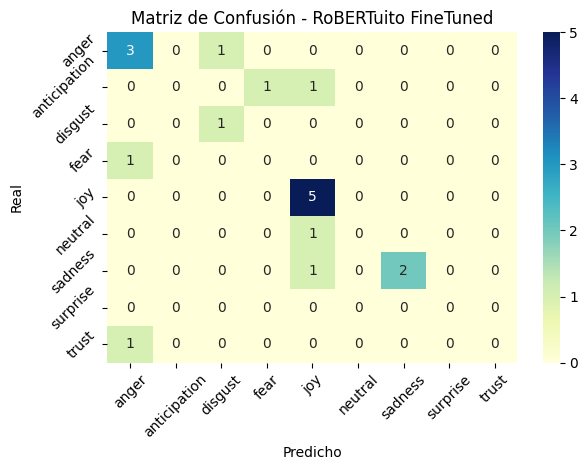

In [ ]:
import time

# Etiquetas en orden (esto lo obtienes del label_encoder)
etiquetas = label_encoder.classes_

# Obtener predicciones
start = time.time()
predictions = trainer.predict(tokenized_dataset["test"])
end = time.time()

y_true = label_encoder.inverse_transform(predictions.label_ids)
y_pred = label_encoder.inverse_transform(np.argmax(predictions.predictions, axis=1))

# Crear el DataFrame si no existe
import pandas as pd
if 'resultadosEmociones' not in globals():
    resultadosEmociones = pd.DataFrame(columns=["Modelo", "Accuracy", "Precision", "Recall", "F1", "Tiempo (s)"])

# Evaluar
evaluar_modelo_emociones("RoBERTuito FineTuned", y_true, y_pred, end - start, etiquetas)


In [ ]:
model.save_pretrained("./robertuito-finetuned-emotions")
tokenizer.save_pretrained("./robertuito-finetuned-emotions")


('./robertuito-finetuned-emotions/tokenizer_config.json',
 './robertuito-finetuned-emotions/special_tokens_map.json',
 './robertuito-finetuned-emotions/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Comprimir el modelo en un zip
shutil.make_archive("robertuito-finetuned-emotions", 'zip', "./robertuito-finetuned-emotions")

# Descargar
files.download("robertuito-finetuned-emotions.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
resultadosEmociones.head(10)

,Modelo,Accuracy,Precision,Recall,F1,Tiempo (s)
0,robertuito-emotion-analysis,0.352273,0.651948,0.442857,0.488133,32.73
1,robertuito-emotion-analysis-personalizado,0.454545,0.385917,0.454545,0.367802,34.29
2,T5,0.318182,0.170770,0.318182,0.198188,92.99
3,BETO,0.147727,0.120382,0.147727,0.132139,39.33
4,XLM-EMO-T,0.136364,0.088316,0.136364,0.103102,50.70
5,RoBERTuito FineTuned,0.611111,0.501389,0.611111,0.532194,7.75


# Analisis adicional
Al tener resultados tan limitados, se optó por realizar una capa adicional de validación.

In [ ]:
df_emo_2 = pd.read_csv("standarizedDataset.csv")

In [ ]:
df_emo_2.head()

,phrase,sentiment,emotion
0,Para llevar a los bebes de un lugar a otro deb...,Positive,joy
1,"En Venezuela, el tráfico aéreo esta tan peligr...",Negative,anticipation
2,"Para tristeza y felicidad, Ed Sheeran al rescate.",Negative,sadness
3,Con razon mi vieja se fue rapido a Santa Fe si...,Negative,sadness
4,Lo lindo de sentir cerca a esa gente con la qu...,Positive,trust


In [ ]:
df_emo_2['emotion'].unique()

array(['joy', 'anticipation', 'sadness', 'trust', 'anger', 'Neutral',
       'surprise', 'disgust', 'fear'], dtype=object)

In [ ]:
df_emo_2['phrase'] = df_emo_2['phrase'].str.lower()
df_emo_2.head()

,phrase,sentiment,emotion
0,para llevar a los bebes de un lugar a otro deb...,Positive,joy
1,"en venezuela, el tráfico aéreo esta tan peligr...",Negative,anticipation
2,"para tristeza y felicidad, ed sheeran al rescate.",Negative,sadness
3,con razon mi vieja se fue rapido a santa fe si...,Negative,sadness
4,lo lindo de sentir cerca a esa gente con la qu...,Positive,trust


In [ ]:
df_emo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   phrase     1935 non-null   object
 1   sentiment  1935 non-null   object
 2   emotion    1935 non-null   object
dtypes: object(3)
memory usage: 45.5+ KB


## Robertuito con clases base


In [ ]:
%%capture
!pip install pysentimiento

Classification Report:

              precision    recall  f1-score   support

       anger       0.83      0.37      0.51       614
     disgust       0.20      0.03      0.06        30
        fear       0.31      0.43      0.36        72
         joy       0.26      0.34      0.29       204
      others       0.31      0.57      0.40       538
     sadness       0.64      0.35      0.45       450
    surprise       0.08      0.19      0.11        27

    accuracy                           0.41      1935
   macro avg       0.38      0.32      0.31      1935
weighted avg       0.54      0.41      0.43      1935



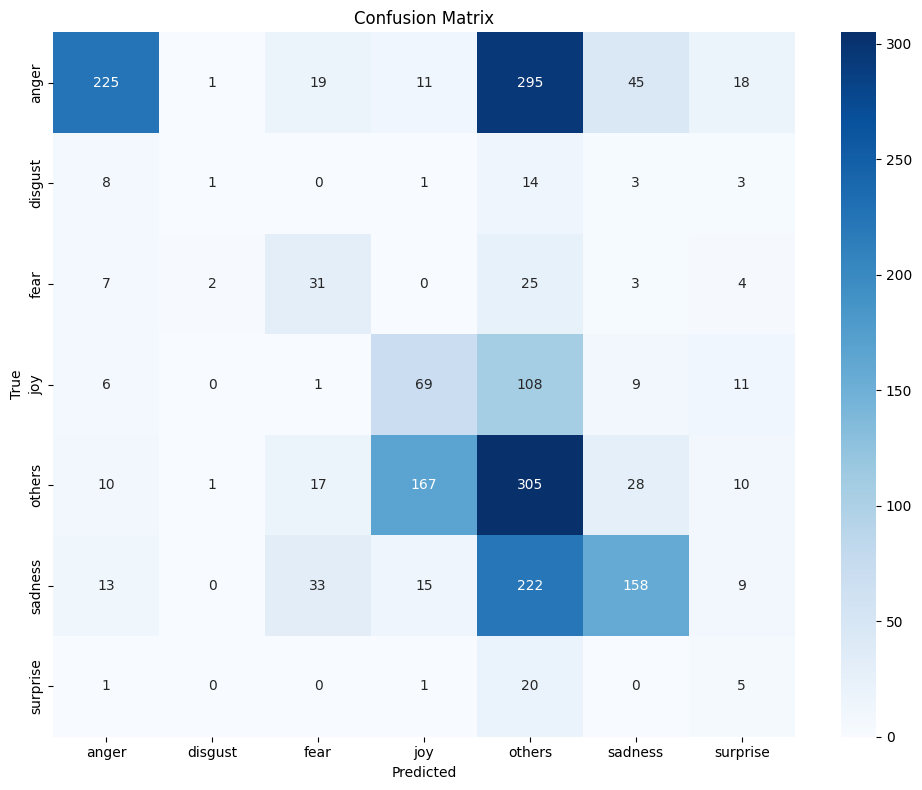


Resumen de métricas globales:
             Modelo  Accuracy  Precision    Recall        F1
0  RoBERTuito - Raw  0.410336   0.542777  0.410336  0.425096


In [ ]:
from pysentimiento import create_analyzer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el analizador de emociones en español
emotion_analyzer = create_analyzer(task="emotion", lang="es")

# Emociones que el modelo puede predecir directamente
model_emotions = {'joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust'}

# Obtener y_true y y_pred
y_true = [
    emotion if emotion in model_emotions else 'others'
    for emotion in df_emo_2['emotion']
]
y_pred = [
    emotion_analyzer.predict(text).output
    for text in df_emo_2['phrase']
]

# Métricas globales
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Guardar métricas en un DataFrame
results_df = pd.DataFrame([{
    "Modelo": "RoBERTuito - Raw",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1
}])

# Reporte de clasificación
print("Classification Report:\n")
print(classification_report(y_true, y_pred, zero_division=0))

# Matriz de confusión
labels = sorted(set(y_true + y_pred))  # Clases presentes
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Mostrar el DataFrame de métricas
print("\nResumen de métricas globales:")
print(results_df)


## T5

In [ ]:
%%capture
!pip install datasets evaluate torch accelerate transformers

pytorch_model.bin:  59%|#####8    | 524M/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]


100%|██████████| 1935/1935 [15:32<00:00,  2.08it/s]



🧪 Classification Report:
              precision    recall  f1-score   support

     sadness       0.41      0.26      0.32       450
         joy       0.13      0.75      0.23       204
        love       0.00      0.00      0.00         0
       anger       0.52      0.18      0.27       614
        fear       0.08      0.33      0.13        72
    surprise       0.00      0.00      0.00        27
       other       0.00      0.00      0.00       568

    accuracy                           0.21      1935
   macro avg       0.16      0.22      0.14      1935
weighted avg       0.28      0.21      0.19      1935



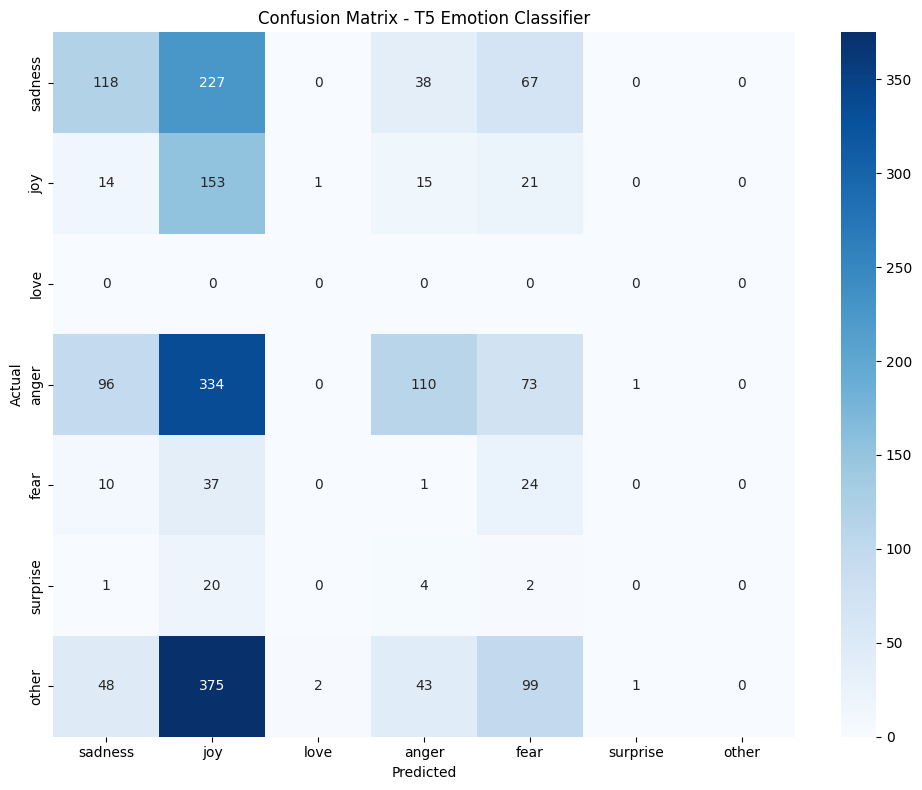

NameError: name 'resultadosEmociones' is not defined

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Emociones que el modelo T5 soporta
emociones_t5 = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Cargar modelo y tokenizer
tokenizer_t5 = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-emotion")

# Función de predicción
def predecir_emocion_t5(texto):
    entrada = f"emotion: {texto}"
    inputs = tokenizer_t5(entrada, return_tensors="pt", truncation=True)
    with torch.no_grad():
        output = model_t5.generate(**inputs)
    emocion = tokenizer_t5.decode(output[0], skip_special_tokens=True)
    return emocion.strip().lower()

# Asumimos que df_emo_2 y resultadosEmociones ya existen en el entorno
y_true = []
y_pred = []

for _, row in tqdm(df_emo_2.iterrows(), total=len(df_emo_2)):
    texto = row['phrase']
    emocion_real = row['emotion'].lower()
    emocion_predicha = predecir_emocion_t5(texto)

    if emocion_predicha not in emociones_t5:
        emocion_predicha = "other"
    if emocion_real not in emociones_t5:
        emocion_real = "other"

    y_true.append(emocion_real)
    y_pred.append(emocion_predicha)

# Calcular métricas
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Agregar resultados al DataFrame existente
results_df.loc[len(results_df)] = ["T5", acc, precision, recall, f1]





🧪 Classification Report:
              precision    recall  f1-score   support

     sadness       0.41      0.26      0.32       450
         joy       0.13      0.75      0.23       204
        love       0.00      0.00      0.00         0
       anger       0.52      0.18      0.27       614
        fear       0.08      0.33      0.13        72
    surprise       0.00      0.00      0.00        27
       other       0.00      0.00      0.00       568

    accuracy                           0.21      1935
   macro avg       0.16      0.22      0.14      1935
weighted avg       0.28      0.21      0.19      1935



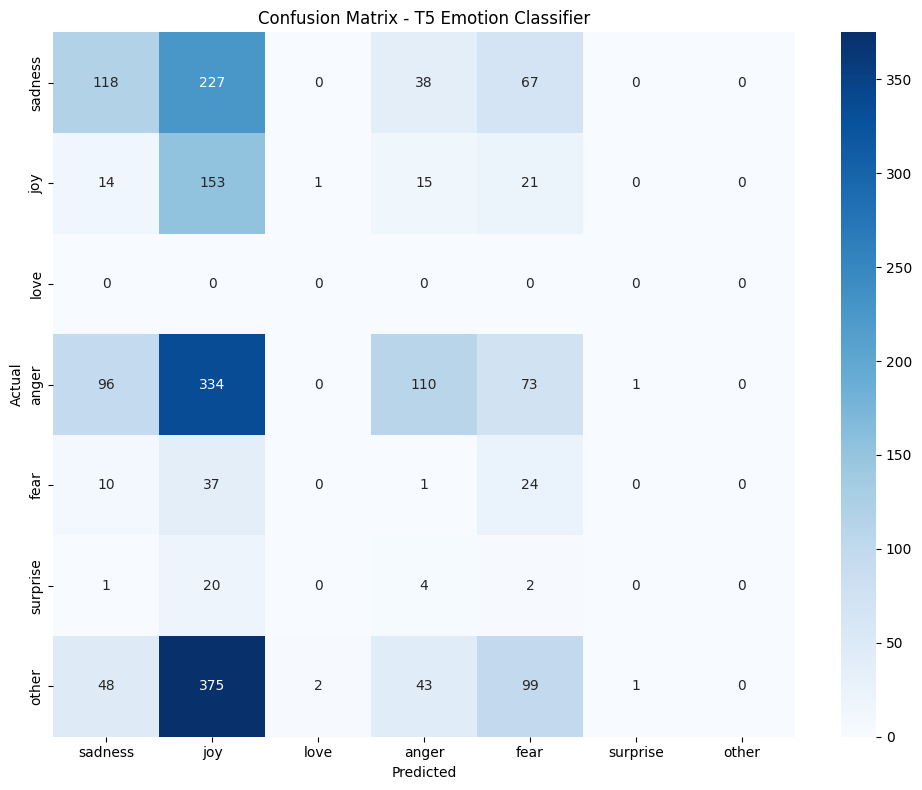

In [ ]:
# Reporte y matriz de confusión
print("\n🧪 Classification Report:")
print(classification_report(y_true, y_pred, labels=emociones_t5 + ["other"], zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=emociones_t5 + ["other"])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=emociones_t5 + ["other"], yticklabels=emociones_t5 + ["other"], cmap="Blues", fmt='d')
plt.title("Confusion Matrix - T5 Emotion Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
results_df

,Modelo,Accuracy,Precision,Recall,F1
0,RoBERTuito - Raw,0.410336,0.542777,0.410336,0.425096
1,T5,0.209302,0.278238,0.209302,0.187971


## BETO

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

100%|██████████| 1935/1935 [05:33<00:00,  5.81it/s]



🧪 Classification Report:
              precision    recall  f1-score   support

         joy       0.12      0.46      0.19       204
       anger       0.04      0.02      0.02       614
     sadness       0.57      0.37      0.45       450
        fear       0.02      0.07      0.03        72
     disgust       0.02      0.10      0.03        30
    surprise       0.00      0.00      0.00        27
     neutral       0.02      0.03      0.02        66
       other       0.00      0.00      0.00       472

    accuracy                           0.15      1935
   macro avg       0.10      0.13      0.09      1935
weighted avg       0.16      0.15      0.13      1935



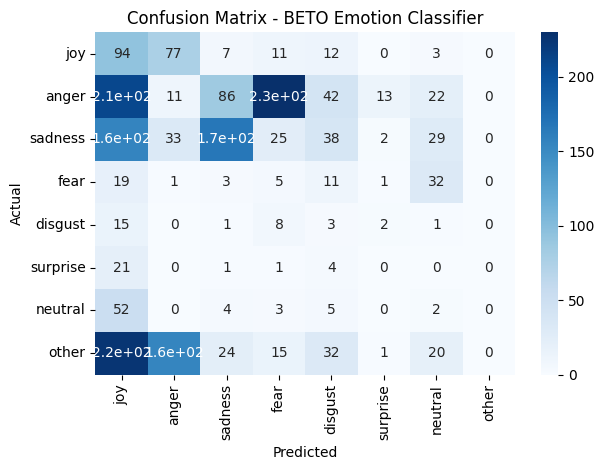

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Emociones soportadas por el modelo BETO
emociones_beto = ['joy', 'anger', 'sadness', 'fear', 'disgust', 'surprise', 'neutral']

# Cargar modelo BETO fine-tuned para análisis de emociones
tokenizer_beto = AutoTokenizer.from_pretrained("finiteautomata/beto-emotion-analysis")
model_beto = AutoModelForSequenceClassification.from_pretrained("finiteautomata/beto-emotion-analysis")

# Función de predicción
def predecir_emocion_beto(texto):
    inputs = tokenizer_beto(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        output = model_beto(**inputs)
    logits = output.logits
    probas = torch.nn.functional.softmax(logits, dim=-1)
    emocion_predicha = emociones_beto[torch.argmax(probas)]
    return emocion_predicha

# Evaluar modelo sobre df_emo_2
y_true = []
y_pred = []

for _, row in tqdm(df_emo_2.iterrows(), total=len(df_emo_2)):
    texto = row['phrase']
    emocion_real = row['emotion'].lower()
    emocion_predicha = predecir_emocion_beto(texto)

    y_true.append(emocion_real if emocion_real in emociones_beto else "other")
    y_pred.append(emocion_predicha if emocion_predicha in emociones_beto else "other")

# Reporte
print("\n🧪 Classification Report:")
print(classification_report(y_true, y_pred, labels=emociones_beto + ["other"], zero_division=0))
report = classification_report(y_true, y_pred, labels=emociones_beto + ["other"], output_dict=True, zero_division=0)
acc = report.get("accuracy", 0.0)
precision = report.get("weighted avg", {}).get("precision", 0.0)
recall = report.get("weighted avg", {}).get("recall", 0.0)
f1 = report.get("weighted avg", {}).get("f1-score", 0.0)

# Añadir resultados al DataFrame de resultados
results_df.loc[len(results_df)] = ["BETO", acc, precision, recall, f1]

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=emociones_beto + ["other"])
sns.heatmap(cm, annot=True, xticklabels=emociones_beto + ["other"], yticklabels=emociones_beto + ["other"], cmap="Blues")
plt.title("Confusion Matrix - BETO Emotion Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## XLM

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Emociones soportadas por el modelo xlm-emo-t
emociones_xlmemo = ['joy', 'anger', 'fear', 'sadness']

# Cargar modelo y tokenizer
tokenizer_xlmemo = AutoTokenizer.from_pretrained("MilaNLProc/xlm-emo-t")
model_xlmemo = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/xlm-emo-t")

# Función de predicción
def predecir_emocion_xlmemo(texto):
    inputs = tokenizer_xlmemo(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        output = model_xlmemo(**inputs)
    logits = output.logits
    probas = torch.nn.functional.softmax(logits, dim=-1)
    emocion_predicha = emociones_xlmemo[torch.argmax(probas)]
    return emocion_predicha

# Evaluar modelo sobre DataFrame
def evaluar_modelo_xlmemo(df_emociones):
    y_true = []
    y_pred = []
    start = time.time()

    for _, row in tqdm(df_emociones.iterrows(), total=len(df_emociones)):
        texto = row['phrase']
        emocion_real = row['emotion'].lower()
        emocion_predicha = predecir_emocion_xlmemo(texto)

        y_true.append(emocion_real if emocion_real in emociones_xlmemo else "other")
        y_pred.append(emocion_predicha if emocion_predicha in emociones_xlmemo else "other")

    end = time.time()

    print("\n🧪 Classification Report:")
    report = classification_report(y_true, y_pred, labels=emociones_xlmemo + ["other"], output_dict=True, zero_division=0)
    acc = report.get("accuracy", 0.0)
    precision = report.get("weighted avg", {}).get("precision", 0.0)
    recall = report.get("weighted avg", {}).get("recall", 0.0)
    f1 = report.get("weighted avg", {}).get("f1-score", 0.0)

    # Añadir resultados al DataFrame results_df
    results_df.loc[len(results_df)] = ["XLM-EMO-T", acc, precision, recall, f1]

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=emociones_xlmemo + ["other"])
    sns.heatmap(cm, annot=True, xticklabels=emociones_xlmemo + ["other"],
                yticklabels=emociones_xlmemo + ["other"], cmap="Purples")
    plt.title("Confusion Matrix - XLM-EMO-T Emotion Classifier")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return y_true, y_pred


100%|██████████| 1935/1935 [05:14<00:00,  6.15it/s]



🧪 Classification Report:


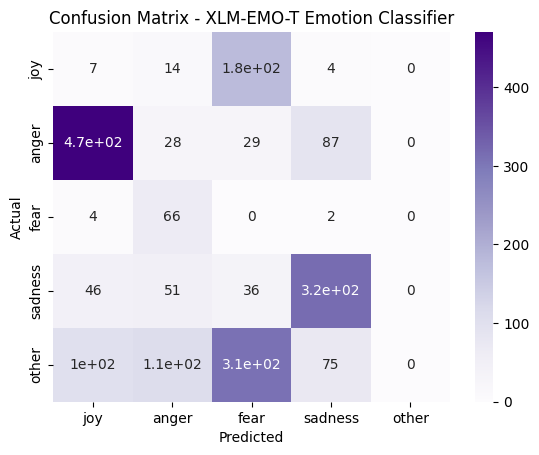

In [ ]:
# Ejecutar evaluación
y_true, y_pred = evaluar_modelo_xlmemo(df_emo_2)

In [ ]:
results_df

,Modelo,Accuracy,Precision,Recall,F1
0,RoBERTuito - Raw,0.410336,0.542777,0.410336,0.425096
1,T5,0.209302,0.278238,0.209302,0.187971
2,BETO,0.145736,0.159230,0.145736,0.134587
3,XLM-EMO-T,0.181912,0.186208,0.181912,0.179592


# Finetuning adicional

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

#  Definir emociones válidas (según tu diccionario)
emociones_validas = ["joy", "anger", "sadness", "disgust", "fear", "neutral", "trust", "surprise", "anticipation"]

label2id = {
    "joy": 0,
    "anger": 1,
    "sadness": 2,
    "disgust": 3,
    "fear": 4,
    "neutral": 5,
    "trust": 6,
    "surprise": 7,
    "anticipation": 8
}
id2label = {v: k for k, v in label2id.items()}

#  Preparar df_emociones
df_emociones_proc = df_emociones.rename(columns={"Transcripción": "text", "Emoción": "labels"})
df_emociones_proc["labels"] = df_emociones_proc["labels"].str.lower()

#  Preparar df_emo_2
df_emo_2_proc = df_emo_2.rename(columns={"phrase": "text", "emotion": "labels"})
df_emo_2_proc["labels"] = df_emo_2_proc["labels"].str.lower()

# Unir ambos
df_finetuning = pd.concat([df_emociones_proc, df_emo_2_proc], ignore_index=True)

# Eliminar columna sentiment de df_finetuning
df_finetuning = df_finetuning.drop(columns=["sentiment"])

df_finetuning["labels"] = df_finetuning["labels"].map(label2id)


In [ ]:
from sklearn.utils import resample
# Combinar todas las clases
df_balanced = pd.DataFrame()

for label_id in df_finetuning["labels"].unique():
    subset = df_finetuning[df_finetuning["labels"] == label_id]
    df_upsampled = resample(subset,
                            replace=True,
                            n_samples=200,  # número al que quieres igualar
                            random_state=42)
    df_balanced = pd.concat([df_balanced, df_upsampled])

# Mezclar el dataset balanceado
df_finetuning_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
dataset = Dataset.from_pandas(df_finetuning_balanced[["text", "labels"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [ ]:
df_finetuning

,text,labels
0,hoy estaba caminando me había comprado mi café...,1
1,hoy dicen panadas con mi mamá estuvimos mucho ...,0
2,hoy me peleo con mi hermano no quería hacer lo...,2
3,pues hoy me lance temprano porque el año de mi...,0
4,en el mes de general en el mes de febrero me f...,0
...,...,...
2018,que lindo es que re rasquen la espalda pero s...,0
2019,"""hombres cuya única preocupación pasa por si s...",1
2020,ahorita quisiera que mi preocupación más grand...,2
2021,mi prima de 4 años se ha enfadado conmigo porq...,1


In [ ]:
from transformers import AutoTokenizer

model_name = "pysentimiento/robertuito-emotion-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = example["labels"]
    return tokens

tokenized_dataset = dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

y_train = tokenized_dataset["train"]["labels"]
unique_classes = np.unique(y_train)
# Balancear pesos de las clases
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [ ]:
from transformers import AutoModelForSequenceClassification

# Cargar el modelo preentrenado y especificar el número de etiquetas
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),  # Asegúrate de que el número de etiquetas sea 9
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Esto permitirá ignorar los errores de tamaño
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-emotion-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_loss_with_weights(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

model.compute_loss = compute_loss_with_weights


In [ ]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./robertuito-emotions-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.1,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),
    report_to="none"
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


<ipython-input-50-a8272fac4809>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.796353,0.488889,0.473256,0.480089,0.442557
2,No log,1.371975,0.616667,0.606608,0.603958,0.565892
3,No log,1.140755,0.669444,0.642851,0.654410,0.629598
4,No log,1.041854,0.686111,0.662688,0.672107,0.653150
5,No log,1.011644,0.691667,0.664509,0.677807,0.657429


TrainOutput(global_step=225, training_loss=1.3448753526475694, metrics={'train_runtime': 100.9172, 'train_samples_per_second': 71.346, 'train_steps_per_second': 2.23, 'total_flos': 473629665484800.0, 'train_loss': 1.3448753526475694, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

preds = trainer.predict(tokenized_dataset["test"])
y_pred = np.argmax(preds.predictions, axis=-1)
y_true = preds.label_ids

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id.keys())))


              precision    recall  f1-score   support

         joy       0.57      0.34      0.43        35
       anger       0.76      0.59      0.67        44
     sadness       0.49      0.60      0.54        30
     disgust       0.77      0.92      0.84        37
        fear       0.84      0.98      0.91        44
     neutral       0.76      0.81      0.78        42
       trust       0.46      0.69      0.55        35
    surprise       0.88      0.96      0.92        51
anticipation       0.45      0.21      0.29        42

    accuracy                           0.69       360
   macro avg       0.66      0.68      0.66       360
weighted avg       0.68      0.69      0.67       360



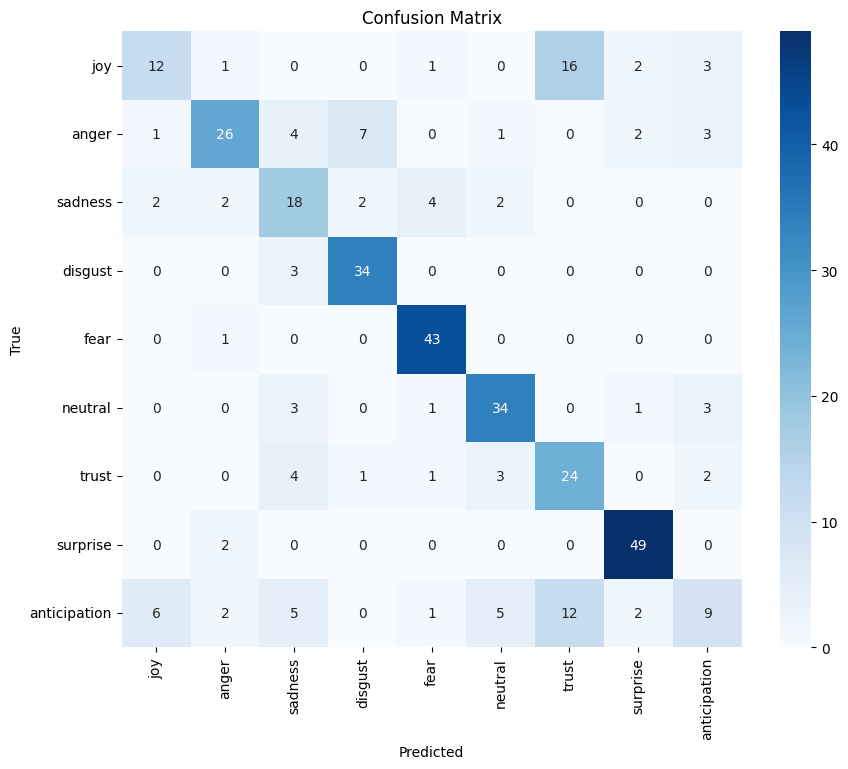

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las predicciones y las etiquetas verdaderas
preds = trainer.predict(tokenized_dataset["test"])
y_pred = np.argmax(preds.predictions, axis=-1)
y_true = preds.label_ids

# Obtener la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label2id.keys()), yticklabels=list(label2id.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Genera el classification report como un diccionario
print("\n🧪 Classification Report:")
report = classification_report(y_true, y_pred, target_names=list(label2id.keys()), output_dict=True)

# Extrae las métricas del reporte
acc = report.get("accuracy", 0.0)
precision = report.get("weighted avg", {}).get("precision", 0.0)
recall = report.get("weighted avg", {}).get("recall", 0.0)
f1 = report.get("weighted avg", {}).get("f1-score", 0.0)

# Añadir resultados al DataFrame results_df
results_df.loc[len(results_df)] = ["Robertuito Finetuned (All data)", acc, precision, recall, f1]

# Ver el DataFrame con los resultados
print(results_df)



🧪 Classification Report:
                            Modelo  Accuracy  Precision    Recall        F1
0                 RoBERTuito - Raw  0.410336   0.542777  0.410336  0.425096
1                               T5  0.209302   0.278238  0.209302  0.187971
2                             BETO  0.145736   0.159230  0.145736  0.134587
3                        XLM-EMO-T  0.181912   0.186208  0.181912  0.179592
4  Robertuito Finetuned (All data)  0.691667   0.681508  0.691667  0.673299
5  Robertuito Finetuned (All data)  0.691667   0.681508  0.691667  0.673299


In [ ]:
model.save_pretrained("./robertuito-emotions-finetuned")
tokenizer.save_pretrained("./robertuito-emotions-finetuned")

('./robertuito-emotions-finetuned/tokenizer_config.json',
 './robertuito-emotions-finetuned/special_tokens_map.json',
 './robertuito-emotions-finetuned/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Comprimir el modelo en un zip
shutil.make_archive("robertuito-emotions-finetuned-alldata", 'zip', "./robertuito-emotions-finetuned")

# Descargar
files.download("robertuito-emotions-finetuned-alldata.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define tu ruta personalizada
save_path = "./modelo_final_robertuito"

# Guarda el modelo y el tokenizer en esa ruta
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

# Comprime solo esa carpeta
shutil.make_archive("modelo_final_robertuito", 'zip', save_path)

'/content/modelo_final_robertuito.zip'

In [ ]:
# Descarga el .zip
files.download("modelo_final_robertuito.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>